In [40]:
import sys
import os
sys.path.insert(0, os.path.dirname(os.getcwd()))
from config import *

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

In [41]:
X = php_X
scaler = StandardScaler().fit(X)
X = (X - scaler.mean_) / np.sqrt(scaler.var_)

y = php_y

In [42]:
X.head()

V1        V2        V3        V4        V5
0  0.489972 -0.451570 -1.048087 -0.598748 -0.020420
1 -0.641324  0.109255  0.292157 -0.916889  0.240245
2  0.870674 -0.459905  0.578212  0.806709  0.835325
3 -0.628497 -0.316313  1.934474 -1.427231 -0.136596
4 -0.596454  0.015939  2.043395 -1.688604 -0.948215

# 1. Clustering

## K-Means

### How to determine the number of clusters (k)
- Elbow Method 
    - within-group variability as small as possible, between-group variability as large as possible
    - the location of an elbow indicates the appropriate number of clusters, balance minimizing the WSS with parsimony of the model
    - [ref1](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set)
    - [ref2](https://en.wikipedia.org/wiki/F-test)
    - [WSS+BSS=TSS](https://stats.stackexchange.com/questions/81954/ssb-sum-of-squares-between-clusters)
- Gap Statistic
    - within-group variability drops as k increase. The gap statistic shows the k at which the clusters differs from cluster among uniformly distributed data.
    - [ref1](https://datasciencelab.wordpress.com/2013/12/27/finding-the-k-in-k-means-clustering/)
    - [how to interpret the result of gap statistic](https://stats.stackexchange.com/questions/95290/how-should-i-interpret-gap-statistic)
    - [python implementation of gap statistic](https://anaconda.org/milesgranger/gap-statistic/notebook)
    - [python package](https://github.com/milesgranger/gap_statistic/blob/master/Example.ipynb)

In [43]:
def elbow_method(X, k_lb, k_ub):
    wgs = []
    pes = []
    for k in range(k_lb, k_ub):
        clstr = KMeans(n_clusters=k, random_state=0)    # the orginal labeled data has 2 classes, so it is reasaonable to set k=2 XXXX
        clstr.fit(X)
        lb = clstr.labels_

        _, cnts = np.unique(lb, return_counts=True)
        between_group_ssd = np.sum(np.sum((clstr.cluster_centers_ - clstr.cluster_centers_.mean(axis=0))**2, axis=1) * cnts)  # weighted by the number of points in each cluster
        within_group_ssd = clstr.inertia_
        pct_explained_ssd = between_group_ssd / (between_group_ssd + within_group_ssd)
        wgs.append(within_group_ssd)
        pes.append(pct_explained_ssd)
    return pes, wgs

Text(0, 0.5, 'BSS / TSS')

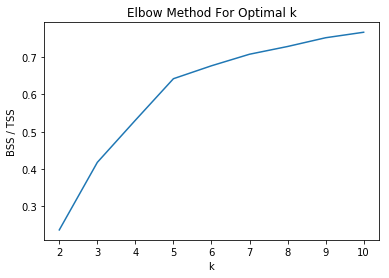

In [44]:
# Elbow Method
pes, wgs = elbow_method(X, 2, 11)
# plt.figure()
# plt.plot(range(2, 12), wgs)
# plt.title('Elbow Method For Optimal k')
# plt.xlabel('k')
# plt.ylabel('WSS')

plt.figure()
plt.plot(range(2, 11), pes)
plt.title('Elbow Method For Optimal k')
plt.xlabel('k')
plt.ylabel('BSS / TSS')
# k = 5

Optimal clusters:  9


Text(0.5, 1.0, 'Gap Values by Cluster Count')

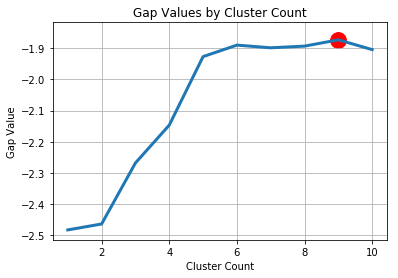

In [59]:
# Gap Statistic
optimalK = OptimalK(parallel_backend='joblib')
n_clusters = optimalK(X.values, cluster_array=np.arange(1, 11))   # random actually
print('Optimal clusters: ', n_clusters)

plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3)
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')

### Visualization of clustering results
- a description of the kind of clusters that you got
- Why did you get the clusters you did? Do they make "sense"?
- Compare and contrast the different algorithms
- What sort of changes might you make to each of those algorithms to improve performance? How much performance was due to the problems you chose?
    - [ref1](https://stats.stackexchange.com/questions/79028/performance-metrics-to-evaluate-unsupervised-learning)
    - [ref2](http://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)

/Users/Quintus/anaconda3/envs/cobra_py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


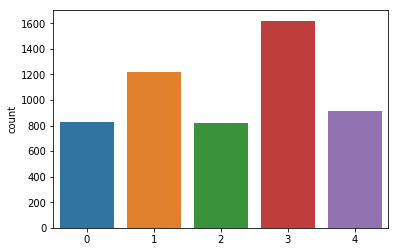

<Figure size 432x288 with 0 Axes>

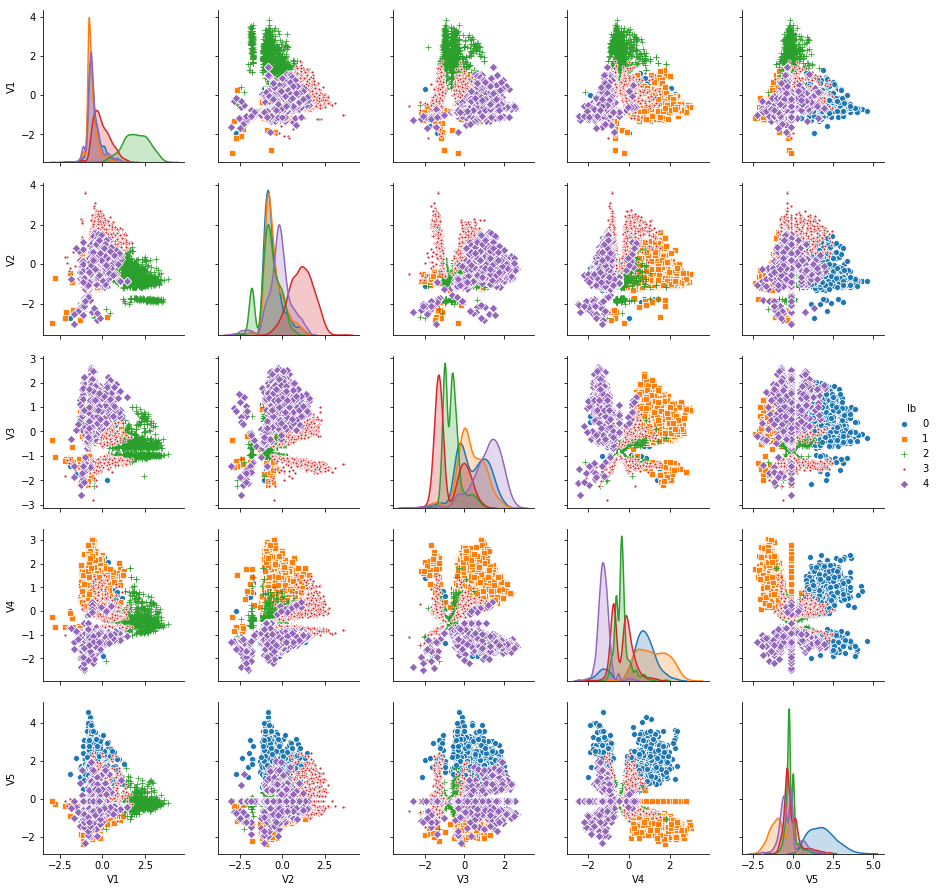

In [127]:
clstr = KMeans(n_clusters=5, random_state=0, verbose=0)    # the orginal labeled data has 2 classes, so it is reasaonable to set k=2
clstr.fit(X)
lb = clstr.labels_
sns.countplot(lb)

# # for test
# plt.figure()
# ax = sns.scatterplot(x='V1', y='V2', hue=lb, style=lb, data=X)

# pairplot
col_names = ['V1','V2','V3','V4','V5']
X_c = X.copy()
X_c['lb'] = lb
plt.figure()
ax = sns.pairplot(X_c, hue='lb', x_vars=col_names, y_vars=col_names, markers=['o', 's', '+', '.', 'D'])

### comparison between original labels and clustering labels

In [43]:
np.sum(y.values == lb) / y.shape[0]  # k=2

0.324759437453738

## Expectation Maximization

### How to determine the number of clusters (k)
- BIC Criterion
    - $BIC = ln(n)k - 2ln(L)$
    - Increasing the number of clusters(k) will always increase the liklihood. But BIC attempt to solve this problem by punishing the number of parameters(k) in the model.
    - [sklearn example](http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html)
    - [wikipedia](https://en.wikipedia.org/wiki/Bayesian_information_criterion)

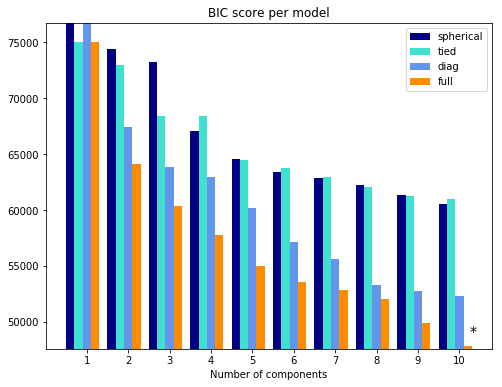

In [192]:
gauss_mix_model_selection(X, k_ub=11, cv_types=['spherical', 'tied', 'diag', 'full'])    # select model based on covariance types and the number of clusters

### Visualization of clustering results
- a description of the kind of clusters that you got
- Why did you get the clusters you did? Do they make "sense"?
- Compare and contrast the different algorithms
- What sort of changes might you make to each of those algorithms to improve performance? How much performance was due to the problems you chose?
    - [ref1](https://stats.stackexchange.com/questions/79028/performance-metrics-to-evaluate-unsupervised-learning)
    - [ref2](http://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)

/Users/Quintus/anaconda3/envs/cobra_py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/Quintus/anaconda3/envs/cobra_py36/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/Quintus/anaconda3/envs/cobra_py36/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/Quintus/anaconda3/envs/cobra_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encounte

<Figure size 432x288 with 0 Axes>

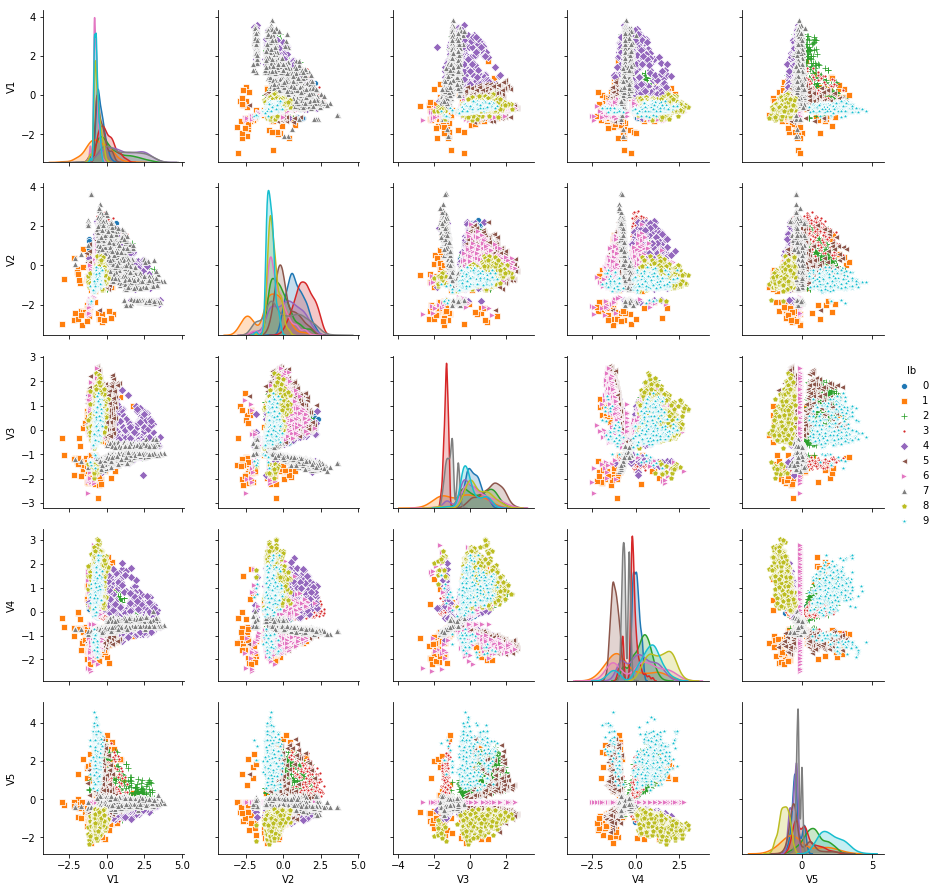

In [187]:
gmm = GaussianMixture(n_components=10, warm_start=True)
lb = gmm.fit_predict(X)

# pairplot
col_names = ['V1','V2','V3','V4','V5']
X_c = X.copy()
X_c['lb'] = lb
plt.figure()
ax = sns.pairplot(X_c, hue='lb', x_vars=col_names, y_vars=col_names, markers=['o', 's', '+', '.', 'D', '<', '>', '^', 'p', '*'])
# From the pair plot, we can see that data have a lot of clusters, instead of just 10. 
# So, it makes sense that as the number of clusters increase we could get better clustering result.
# However, considering the model complexity, we may choose relative small k. 

# 2. Dimensionality Reduction

## PCA
- Visualization of data in new spaces
- For PCA, what is the distribution of eigenvalues?

In [72]:
pca = PCA(n_components=5)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [73]:
pca.explained_variance_  # eigenvalues of X^T*X

array([1.46524769, 1.10974644, 1.0286768 , 0.94192716, 0.45532732])

In [74]:
print(np.sum(pca.explained_variance_ratio_[:4]) / np.sum(pca.explained_variance_ratio_))
pca.explained_variance_ratio_  # ratio
# The 4 most import components accounts for almost 91%. If you really want to reduce the dimension, you can choose the first 4 components. 
# However, for this particular problem, the distribution of variance is pretty even. And the dimension of original data is also small. 

0.9089513871063819


array([0.29299531, 0.22190822, 0.20569729, 0.18835057, 0.09104861])

In [75]:
pca.components_  # U / eigenvectors / Principal axes in feature space, representing the directions of maximum variance in the data. 

array([[-0.50906595, -0.42867471,  0.60144425,  0.43126458,  0.09677567],
       [ 0.6364699 , -0.7183826 , -0.14828397,  0.22961107,  0.06421157],
       [ 0.03528293, -0.0900035 ,  0.18533765, -0.49547788,  0.84309318],
       [-0.18868427,  0.18636126, -0.54672743,  0.61118073,  0.50716364],
       [-0.5467278 , -0.50728028, -0.53199224, -0.37715967, -0.13597894]])

In [119]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X)
print(X_pca.shape)
X_pca               # np.dot(X, np.transpose(pca.components_)) gives S = U^T*X

(5404, 4)


array([[-0.94641269,  0.65287657,  0.14313131,  0.02011305],
       [ 0.08318587, -0.7250941 ,  0.67853385, -0.45690264],
       [ 0.53042581,  1.03767209,  0.48382829,  0.350576  ],
       ...,
       [ 1.41793916,  0.79368581, -1.5032064 , -0.63615312],
       [ 0.86488486, -0.8831684 ,  0.01827329, -2.35700706],
       [ 1.25072458, -0.05336363, -1.24825398, -0.49924   ]])

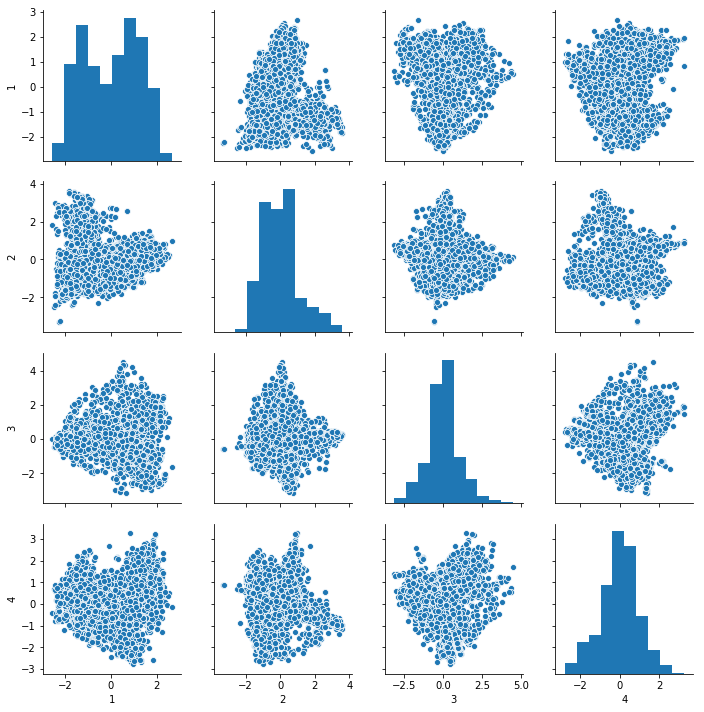

In [77]:
df = pd.DataFrame(X_pca, columns=range(1, X_pca.shape[1]+1))
ax = sns.pairplot(df, x_vars=df.columns, y_vars=df.columns)
# From the top-right subfigure, we can tell that in the direction of first component, the data is more dispersed than the others. 
# From new feature 1 to 5, it is clear that data looks to be less dispersed.

In [78]:
np.diag(np.cov(np.transpose(X_pca)))   # variances of the components are same as the eigenvalues of X^T*X

array([1.46524769, 1.10974644, 1.0286768 , 0.94192716])

## ICA
$X=AS$, $S=W^TX$
- Visualization of data in new spaces
- How kurtotic are the distributions?
    - The distribution of independent components must be non-gaussian for ICA to be possible
- Do the projection axes for ICA seem to capture anything "meaningful"?

In [46]:
ica = FastICA(n_components=5, max_iter=200, random_state=0)
ica.fit(X)

/Users/Quintus/anaconda3/envs/cobra_py36/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
    n_components=5, random_state=0, tol=0.0001, w_init=None, whiten=True)

In [47]:
print(ica.components_.shape)
ica.components_                  # The unmixing matrix with shape (n_components, n_features)

(5, 5)


array([[-8.08890793e-04,  1.00731742e-03, -1.69985360e-04,
         1.04700769e-03, -1.34319780e-02],
       [-1.02495788e-02,  7.36576792e-03,  2.62723615e-05,
        -3.56176662e-03,  8.78652338e-04],
       [ 1.84942198e-03, -2.79091792e-03,  6.40055468e-03,
        -1.17709928e-02, -1.82949503e-03],
       [ 9.44025311e-03,  1.10820877e-02,  1.18540155e-02,
         6.47262182e-03,  1.76720343e-03],
       [ 5.54707221e-03,  6.02445791e-03, -6.91378440e-03,
        -3.66653536e-03,  3.97113443e-04]])

In [48]:
np.dot(X, np.transpose(ica.components_))   # S = W^T*X

array([[-0.00102566, -0.00626104,  0.00254334, -0.01671447,  0.00943092],
       [-0.00360781,  0.01086256,  0.01073213, -0.00689037, -0.00146197],
       [-0.01164128, -0.01443574, -0.00442931,  0.01667453, -0.00456473],
       ...,
       [ 0.01779306, -0.01455725, -0.00408116,  0.0145579 , -0.01737465],
       [ 0.01467917,  0.00924814,  0.02975623, -0.002533  , -0.01379811],
       [ 0.01718348, -0.00020078, -0.0018628 , -0.0046141 , -0.01576605]])

<BarContainer object of 5 artists>

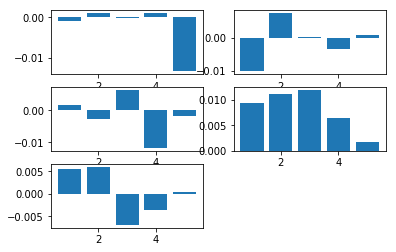

In [49]:
plt.subplot(321)
plt.bar(range(1, 6), ica.components_[0, :])
plt.subplot(322)
plt.bar(range(1, 6), ica.components_[1, :])
plt.subplot(323)
plt.bar(range(1, 6), ica.components_[2, :])
plt.subplot(324)
plt.bar(range(1, 6), ica.components_[3, :])
plt.subplot(325)
plt.bar(range(1, 6), ica.components_[4, :])
# The 1st component mainly puts weight on the 5th feature.
# The 2nd component mainly puts weight on the 1st and 2nd feature.
# The 3rd component mainly puts weight on the 3rd and 4th feature.

In [50]:
X_ica = ica.fit_transform(X)
print(X_ica.shape)
X_ica

(5404, 5)


/Users/Quintus/anaconda3/envs/cobra_py36/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


array([[-0.00102566, -0.00626104,  0.00254334, -0.01671447,  0.00943092],
       [-0.00360781,  0.01086256,  0.01073213, -0.00689037, -0.00146197],
       [-0.01164128, -0.01443574, -0.00442931,  0.01667453, -0.00456473],
       ...,
       [ 0.01779306, -0.01455725, -0.00408116,  0.0145579 , -0.01737465],
       [ 0.01467917,  0.00924814,  0.02975623, -0.002533  , -0.01379811],
       [ 0.01718348, -0.00020078, -0.0018628 , -0.0046141 , -0.01576605]])

In [51]:
kurtosis(X_ica)    
# kurtosis = 0 for normal for this function
# how large the kurtosis to be such that the distribution is very different from normal?
# TEMP: kertosiss are small, so the distribution is not that different from normal. (fat tail and spiky distribution)

array([ 1.63414508,  1.0147939 , -0.17432088,  3.4376624 , -1.21938628])

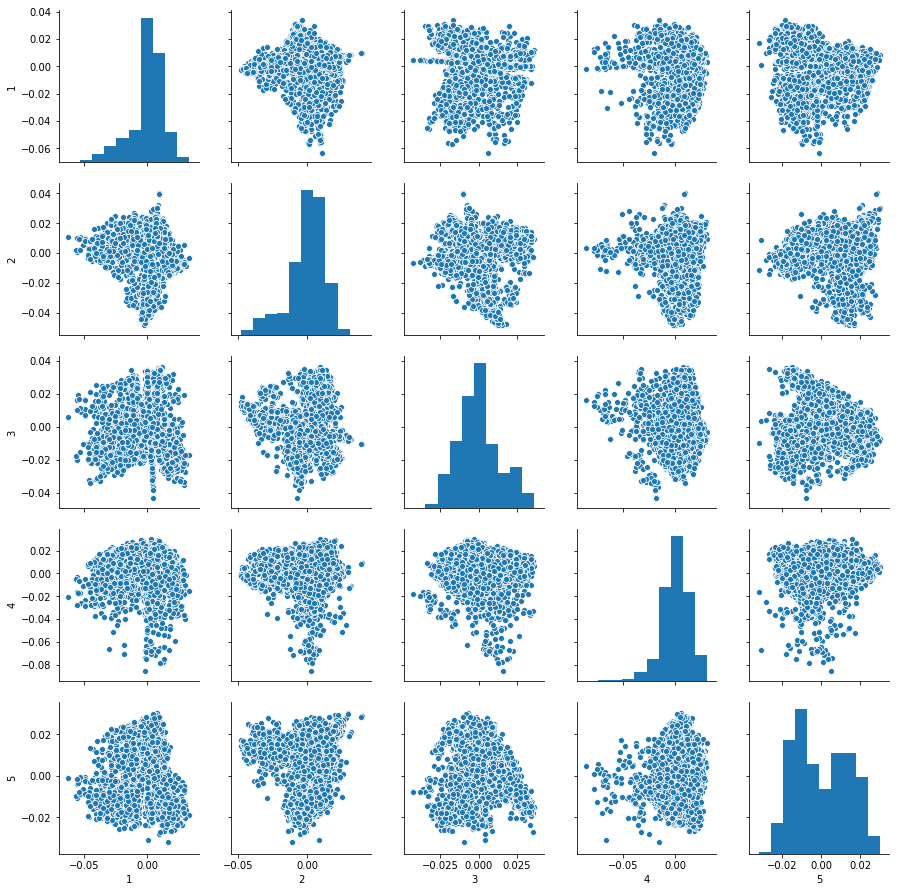

In [85]:
df = pd.DataFrame(X_ica, columns=range(1, 6))
ax = sns.pairplot(df, x_vars=df.columns, y_vars=df.columns)
# 

## Randomized Projections
- How well is the data reconstructed by the randomized projections?
- How much variation did you get when you re-ran your RP several times?

In [62]:
transformer = GaussianRandomProjection(n_components=4, random_state=0)
X_rp = transformer.fit_transform(X)

In [63]:
X_rp

array([[-0.8610155 , -0.34790853, -0.73283934, -0.23308719],
       [-1.20382162,  0.4398093 ,  0.14196213, -0.30146845],
       [ 2.6427823 , -0.55782042,  0.18277797, -0.48806541],
       ...,
       [ 1.0194066 , -0.92856815, -0.30877834,  0.10578342],
       [-2.65175929, -0.1061935 , -0.0327635 , -0.30164202],
       [-0.86222939, -0.25358204, -0.51152833, -0.03704867]])

In [ ]:
# for test
dst = DecisionTreeClassifier(max_depth=16, criterion='gini')
clf = AdaBoostClassifier(base_estimator=dst, n_estimators=90, learning_rate=1)
clf.fit(hwd_X, hwd_y)

y_prob = clf.predict_proba(hwd_X)
accuracy_score(hwd_y, y_prob.argmax(axis=1))

In [112]:
# Adaboost
def rp_boost(X, y):   # numpy array required
    scores_by_sim = []
    for seed in range(3):
        scores_by_d = []
        for d in range(1, X.shape[1]+1):
            rp = GaussianRandomProjection(n_components=d, random_state=seed)
            X_rp = rp.fit_transform(X)
            rs = ShuffleSplit(n_splits=5, test_size=.2, random_state=0)
            acc = []
            for train_idx, cv_idx in rs.split(X_rp):
                X_train, X_cv = X_rp[train_idx, :], X_rp[cv_idx, :]
                y_train, y_cv = y[train_idx], y[cv_idx]

                dst = DecisionTreeClassifier(max_depth=16, criterion='gini')
                clf = AdaBoostClassifier(base_estimator=dst, n_estimators=90, learning_rate=1)
                clf.fit(X_train, y_train)
                y_prob = clf.predict(X_cv)

                acc.append(accuracy_score(y_cv, y_prob))
            score = np.mean(np.array(acc))
            scores_by_d.append(score)
        scores_by_sim.append(scores_by_d)
    return scores_by_sim

In [113]:
%%time
scores = rp_boost(X.values, y.values)

CPU times: user 2min 10s, sys: 1.15 s, total: 2min 11s
Wall time: 2min 15s


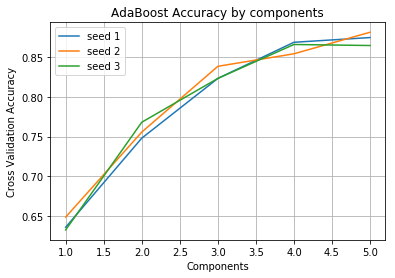

In [114]:
plt.plot(range(1, 6), np.transpose(np.array(scores)))
plt.title('AdaBoost Accuracy by components')
plt.xlabel('Components')
plt.ylabel('Cross Validation Accuracy')
plt.legend(['seed 1', 'seed 2', 'seed 3'])
plt.grid(True)

In [115]:
# NN
def rp_nn(X, y):   # numpy array required
    scores_by_sim = []
    for seed in range(3):
        scores_by_d = []
        for d in range(1, X.shape[1]+1):
            rp = GaussianRandomProjection(n_components=d, random_state=seed)
            X_rp = rp.fit_transform(X)
            rs = ShuffleSplit(n_splits=5, test_size=.2, random_state=0)
            acc = []
            for train_idx, cv_idx in rs.split(X_rp):
                X_train, X_cv = X_rp[train_idx, :], X_rp[cv_idx, :]
                y_train, y_cv = y[train_idx], y[cv_idx]

                K.clear_session()
                model = Sequential()
                model.add(Dense(20, activation='relu', name="hidden_1", input_dim=X_rp.shape[1]))
                model.add(Dense(20, activation='relu', name="hidden_2"))
                model.add(Dense(1, activation='sigmoid', name="op"))
                model.compile(optimizer=Adam(lr=1e-2), loss='binary_crossentropy', metrics=['accuracy'])

                history = model.fit(X_train, y_train, validation_data=(X_cv, y_cv), epochs=10, batch_size=256, verbose=0)
                acc.append(history.history['val_acc'][-1])

            score = np.mean(np.array(acc))
            scores_by_d.append(score)
        scores_by_sim.append(scores_by_d)
    return scores_by_sim

In [116]:
%%time
scores = rp_nn(X.values, y.values)

CPU times: user 3min 2s, sys: 5.35 s, total: 3min 7s
Wall time: 2min 24s


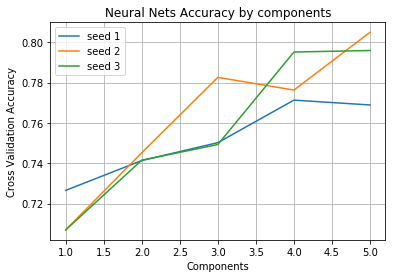

In [117]:
plt.plot(range(1, 6), np.transpose(np.array(scores)))
plt.title('Neural Nets Accuracy by components')
plt.xlabel('Components')
plt.ylabel('Cross Validation Accuracy')
plt.legend(['seed 1', 'seed 2', 'seed 3'])
plt.grid(True)

## Feature selection algorithm - Information Gain in Decision Tree

In [79]:
params = {'criterion': 'entropy', 'max_depth': 12, 'max_features': 5}
clf = DecisionTreeClassifier(**params)
clf = clf.fit(X, y)
print(clf.feature_importances_)

model = SelectFromModel(clf, threshold='median', prefit=True)
X_ig = model.transform(X)    # select 1, 3, 4
X_ig.shape

[0.22893192 0.14579594 0.13668311 0.3595339  0.12905513]


(5404, 3)

In [80]:
fi = clf.feature_importances_
fi

array([0.22893192, 0.14579594, 0.13668311, 0.3595339 , 0.12905513])

In [28]:
np.argsort(fi)[::-1][:6]

array([3, 0, 1, 2, 4])

In [96]:
def ig_boost(X, y):   # numpy array required
    scores_by_d = []

    params = {'criterion': 'entropy', 'max_depth': 12, 'max_features': 5}
    clf = DecisionTreeClassifier(**params)
    clf.fit(X, y)
    fi = clf.feature_importances_
    index = np.argsort(fi)[::-1]

    for d in range(1, X.shape[1]+1):
        X_tf = X[:, index[:d]]

        rs = ShuffleSplit(n_splits=5, test_size=.2, random_state=0)
        acc = []
        for train_idx, cv_idx in rs.split(X_tf):
            X_train, X_cv = X_tf[train_idx, :], X_tf[cv_idx, :]
            y_train, y_cv = y[train_idx], y[cv_idx]

            dst = DecisionTreeClassifier(max_depth=16, criterion='gini')
            clf = AdaBoostClassifier(base_estimator=dst, n_estimators=90, learning_rate=1)
            clf.fit(X_train, y_train)
            y_prob = clf.predict(X_cv)

            acc.append(accuracy_score(y_cv, y_prob))
        score = np.mean(np.array(acc))
        scores_by_d.append(score)
    return scores_by_d

In [108]:
scores = ig_boost(X.values, y.values)

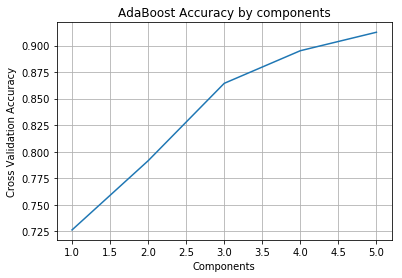

In [109]:
plt.plot(range(1, len(scores)+1), np.transpose(np.array(scores)))
plt.title('AdaBoost Accuracy by components')
plt.xlabel('Components')
plt.ylabel('Cross Validation Accuracy')
plt.grid(True)

In [99]:
def ig_nn(X, y):   # numpy array required
    scores_by_d = []

    params = {'criterion': 'entropy', 'max_depth': 12, 'max_features': 5}
    clf = DecisionTreeClassifier(**params)
    clf.fit(X, y)
    fi = clf.feature_importances_
    index = np.argsort(fi)[::-1]

    for d in range(1, X.shape[1]+1):
        X_tf = X[:, index[:d]]

        rs = ShuffleSplit(n_splits=5, test_size=.2, random_state=0)
        acc = []
        for train_idx, cv_idx in rs.split(X_tf):
            X_train, X_cv = X_tf[train_idx, :], X_tf[cv_idx, :]
            y_train, y_cv = y[train_idx], y[cv_idx]

            K.clear_session()
            model = Sequential()
            model.add(Dense(20, activation='relu', name="hidden_1", input_dim=X_tf.shape[1]))
            model.add(Dense(20, activation='relu', name="hidden_2"))
            model.add(Dense(1, activation='sigmoid', name="op"))
            model.compile(optimizer=Adam(lr=1e-2), loss='binary_crossentropy', metrics=['accuracy'])

            history = model.fit(X_train, y_train, validation_data=(X_cv, y_cv), epochs=10, batch_size=256, verbose=0)
            acc.append(history.history['val_acc'][-1])
        score = np.mean(np.array(acc))
        scores_by_d.append(score)
    return scores_by_d

In [110]:
scores = ig_nn(X.values, y.values)

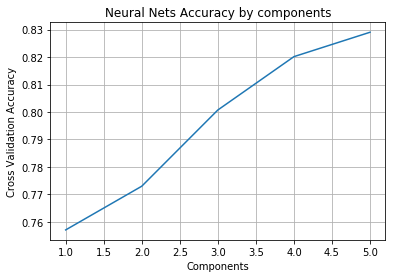

In [111]:
plt.plot(range(1, len(scores)+1), np.transpose(np.array(scores)))
plt.title('Neural Nets Accuracy by components')
plt.xlabel('Components')
plt.ylabel('Cross Validation Accuracy')
plt.grid(True)

# 3. Dimensionality Reduction + Clustering
- When you reproduced your clustering experiments on the datasets projected onto the new spaces created by ICA, PCA, and RP, did you get the same clusters as before? 
- Different clusters? Why? Why not?

## 3.1 PCA
- [PCA will not change the relative distance between points as long as no eigenvalue is discarded](https://stats.stackexchange.com/questions/149539/distances-in-pca-space)

### 3.1.1 K-Means

Text(0, 0.5, 'BSS / TSS')

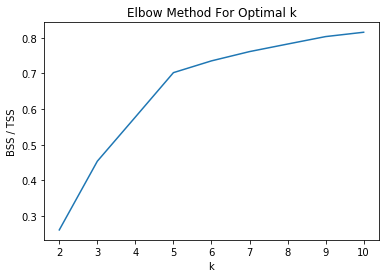

In [120]:
# Elbow Method
pes, wgs = elbow_method(X_pca, 2, 11)

plt.figure()
plt.plot(range(2, 11), pes)
plt.title('Elbow Method For Optimal k')
plt.xlabel('k')
plt.ylabel('BSS / TSS')

Optimal clusters:  5


Text(0.5, 1.0, 'Gap Values by Cluster Count')

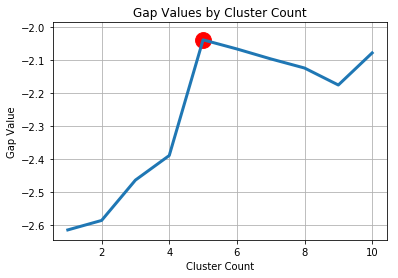

In [123]:
# Gap Statistic
optimalK = OptimalK(parallel_backend='joblib')
n_clusters = optimalK(X_pca, cluster_array=np.arange(1, 11))   # random actually
print('Optimal clusters: ', n_clusters)

plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3)
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')

/Users/Quintus/anaconda3/envs/cobra_py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

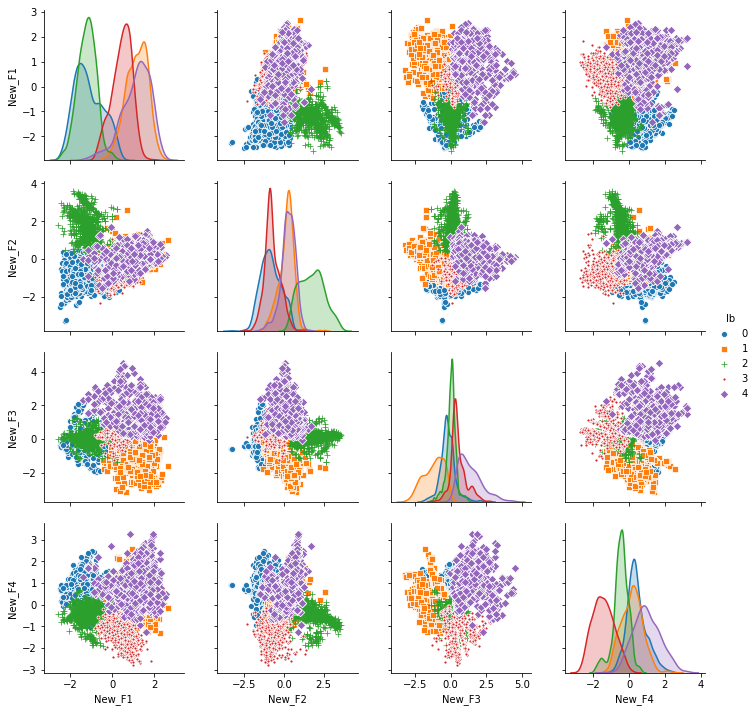

In [136]:
clstr = KMeans(n_clusters=5, random_state=0, verbose=0)
clstr.fit(X_pca)
lb_pca = clstr.labels_

# pairplot
col_names = ['New_F1','New_F2','New_F3','New_F4']
X_df = pd.DataFrame(X_pca, columns=col_names)
X_c = X_df.copy()
X_c['lb'] = lb_pca
plt.figure()
ax = sns.pairplot(X_c, hue='lb', x_vars=col_names, y_vars=col_names, markers=['o', 's', '+', '.', 'D'])
# As PCA extract the axes on which data has most variance, the PCA components are most spread out. In hence, Clusters become more visibile. (remove noise)

In [137]:
np.sum(lb == lb_pca) / lb.shape[0]
# PCA changes the basis of data space, which is just perform rotation on the data. And diagonal matrix streches the data. 
# Thus PCA will not change the relative distance between points as long as no eigenvalue is discarded. 
# However, we reduce the dimension from 5 to 4. The relative distances have been changed. 

0.3771280532938564

### 3.1.2 Expectation Maximization

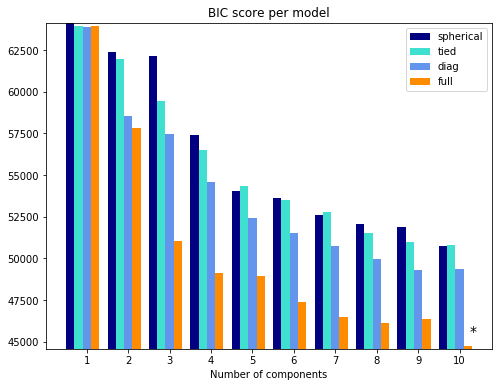

In [182]:
gauss_mix_model_selection(X_pca, k_ub=11, cv_types=['spherical', 'tied', 'diag', 'full'])    # select model based on covariance types and the number of clusters
# Though we try to select the best model based on BIC, we can also add an extra constriant on the number of clusters for the sake of pasimony of model. 
# It is obvious that the BIC of the orange bar slow down its decreasing speed since 3. It is reasonable to set k equal to 3.
# The BIC of EM model before applying PCA decreases gradually without a big jump.
# In contrast, figure below shows a better way to seperate the clusters in the data when taking into account parsimony of model.

/Users/Quintus/anaconda3/envs/cobra_py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

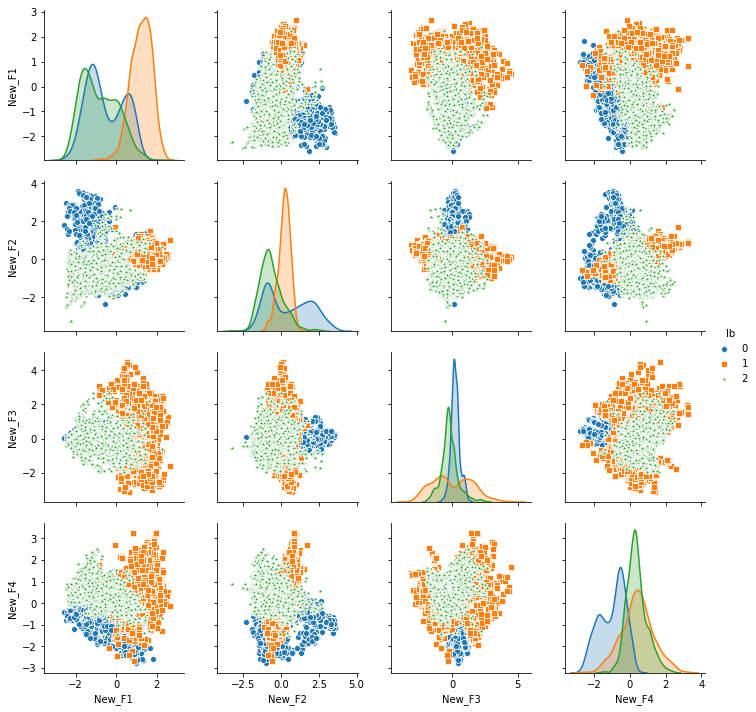

In [186]:
gmm = GaussianMixture(n_components=3, warm_start=True)
lb_pca = gmm.fit_predict(X_pca)

# pairplot
col_names = ['New_F1','New_F2','New_F3','New_F4']
X_df = pd.DataFrame(X_pca, columns=col_names)
X_c = X_df.copy()
X_c['lb'] = lb_pca
plt.figure()
ax = sns.pairplot(X_c, hue='lb', x_vars=col_names, y_vars=col_names, markers=['o', 's', '*'])
# Again in the axes of principal components, the clusters become more visibile. 

In [188]:
# compare with previous model
gmm = GaussianMixture(n_components=10, warm_start=True)
lb_pca = gmm.fit_predict(X_pca)
np.sum(lb == lb_pca) / lb.shape[0]

0.026461880088823095

## 3.2 ICA

### 3.2.1 K-Means

Text(0, 0.5, 'BSS / TSS')

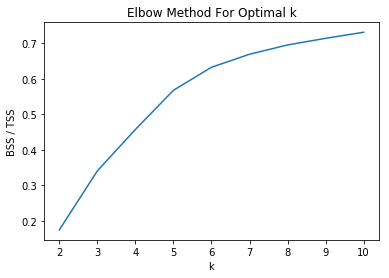

In [52]:
# Elbow Method
pes, wgs = elbow_method(X_ica, 2, 11)
plt.figure()
plt.plot(range(2, 11), pes)
plt.title('Elbow Method For Optimal k')
plt.xlabel('k')
plt.ylabel('BSS / TSS')
# k = 6

Optimal clusters:  7


Text(0.5, 1.0, 'Gap Values by Cluster Count')

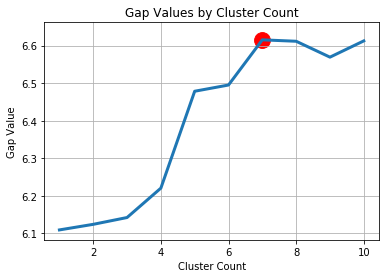

In [53]:
# Gap Statistic
optimalK = OptimalK(parallel_backend='joblib')
n_clusters = optimalK(X_ica, cluster_array=np.arange(1, 11))   # random actually
print('Optimal clusters: ', n_clusters)

plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3)
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')

/Users/Quintus/anaconda3/envs/cobra_py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

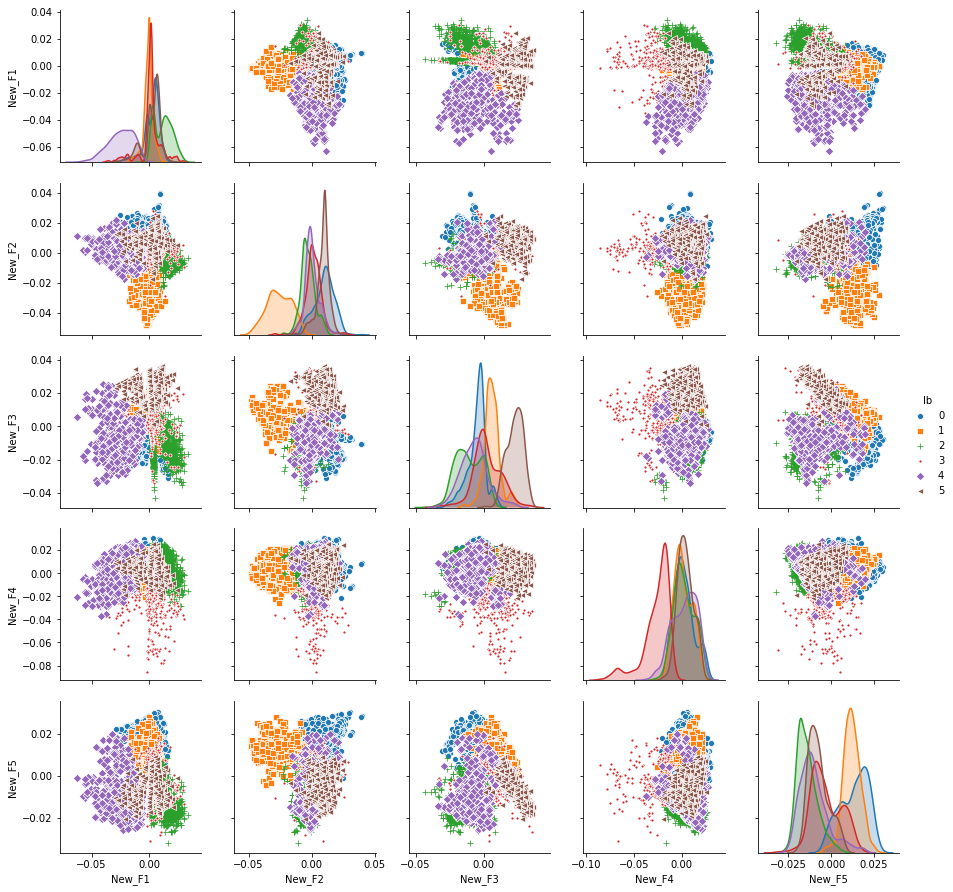

In [54]:
clstr = KMeans(n_clusters=6, random_state=0, verbose=0)
clstr.fit(X_ica)
lb_ica = clstr.labels_

# pairplot
col_names = ['New_F1','New_F2','New_F3','New_F4', 'New_F5']
X_df = pd.DataFrame(X_ica, columns=col_names)
X_c = X_df.copy()
X_c['lb'] = lb_ica
plt.figure()
ax = sns.pairplot(X_c, hue='lb', x_vars=col_names, y_vars=col_names, markers=['o', 's', '+', '.', 'D', '<'])
# Recovering the underlying source by ICA seems to do not help in clustering. The clusters tend to overlap more than using PCA. ???

### 3.2.2 Expectation Maximization

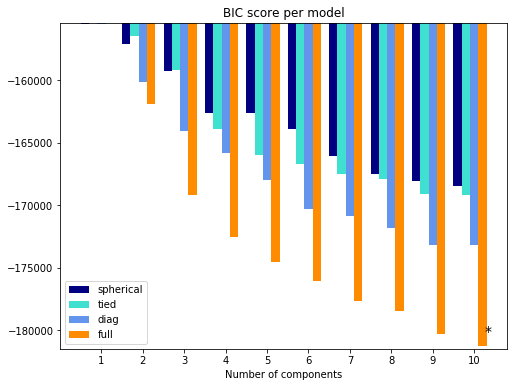

In [124]:
gauss_mix_model_selection(X_ica, k_ub=11, cv_types=['spherical', 'tied', 'diag', 'full'])

/Users/Quintus/anaconda3/envs/cobra_py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

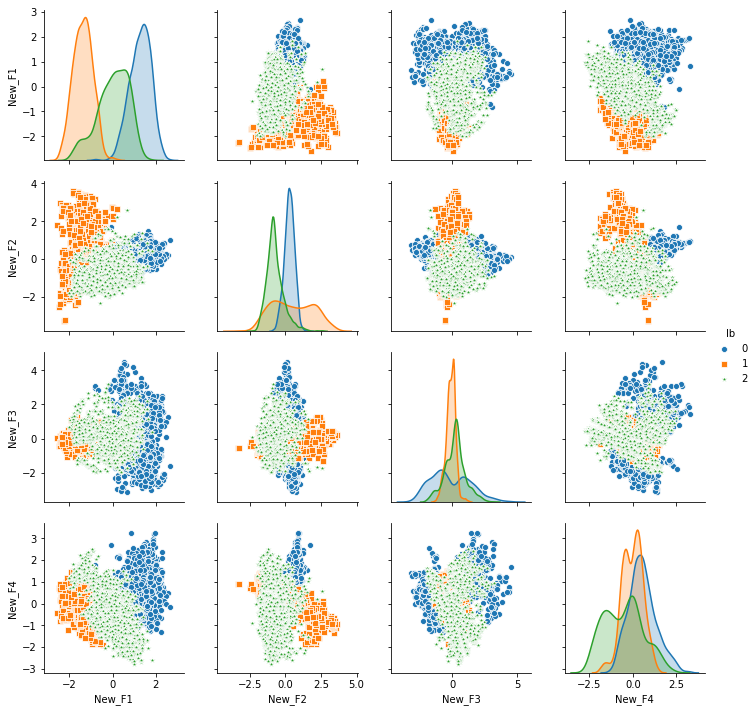

In [126]:
gmm = GaussianMixture(n_components=3, warm_start=True)
lb_ica = gmm.fit_predict(X_pca)

# pairplot
col_names = ['New_F1','New_F2','New_F3','New_F4']
X_df = pd.DataFrame(X_pca, columns=col_names)
X_c = X_df.copy()
X_c['lb'] = lb_ica
plt.figure()
ax = sns.pairplot(X_c, hue='lb', x_vars=col_names, y_vars=col_names, markers=['o', 's', '*'])

## 3.3 RP

In [67]:
X_rp.shape   # project data to dim 4

(5404, 4)

Text(0, 0.5, 'BSS / TSS')

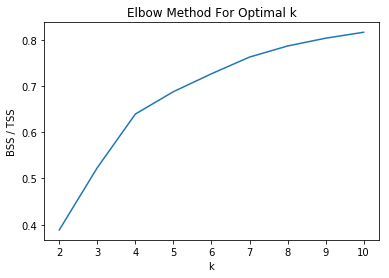

In [65]:
# Elbow Method
pes, wgs = elbow_method(X_rp, 2, 11)
plt.figure()
plt.plot(range(2, 11), pes)
plt.title('Elbow Method For Optimal k')
plt.xlabel('k')
plt.ylabel('BSS / TSS')
# k = 4

Optimal clusters:  8


Text(0.5, 1.0, 'Gap Values by Cluster Count')

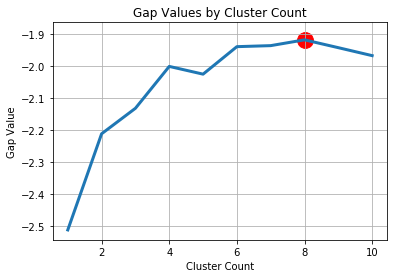

In [68]:
# Gap Statistic
optimalK = OptimalK(parallel_backend='joblib')
n_clusters = optimalK(X_rp, cluster_array=np.arange(1, 11))   # random actually
print('Optimal clusters: ', n_clusters)

plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3)
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
# the shape of curve is consistent with elbow method

/Users/Quintus/anaconda3/envs/cobra_py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

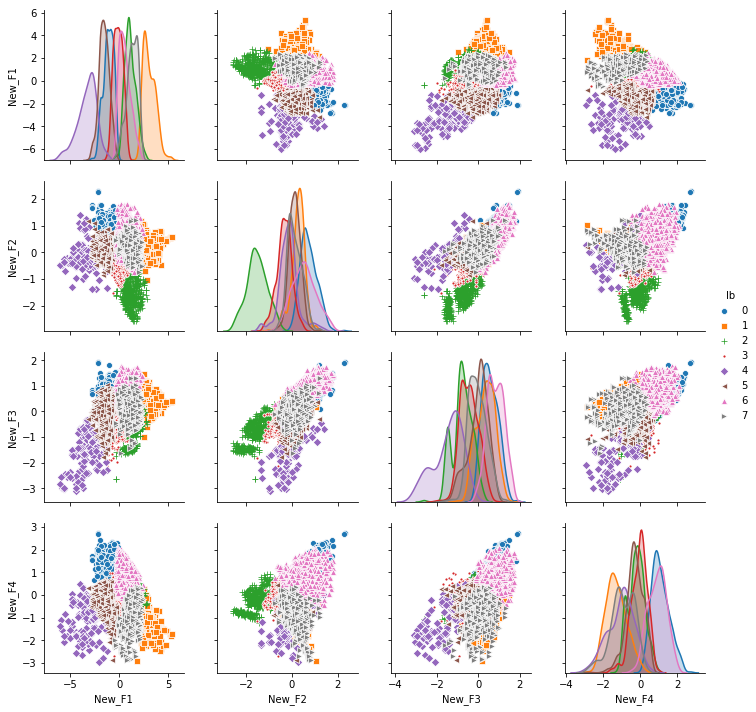

In [71]:
clstr = KMeans(n_clusters=8, random_state=0, verbose=0)
clstr.fit(X_rp)
lb_rp = clstr.labels_

# pairplot
col_names = ['New_F1','New_F2','New_F3','New_F4']
X_df = pd.DataFrame(X_rp, columns=col_names)
X_c = X_df.copy()
X_c['lb'] = lb_rp
plt.figure()
ax = sns.pairplot(X_c, hue='lb', x_vars=col_names, y_vars=col_names, markers=['o', 's', '+', '.', 'D', '<', '^', '>'])

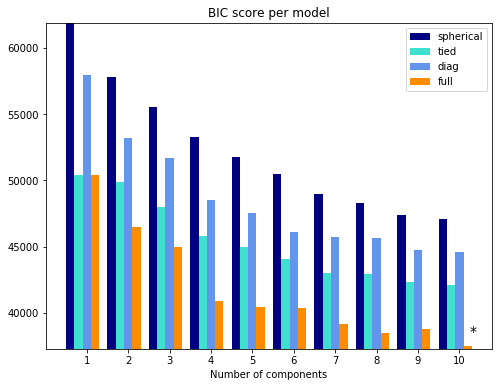

In [73]:
gauss_mix_model_selection(X_rp, k_ub=11, cv_types=['spherical', 'tied', 'diag', 'full'])

/Users/Quintus/anaconda3/envs/cobra_py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

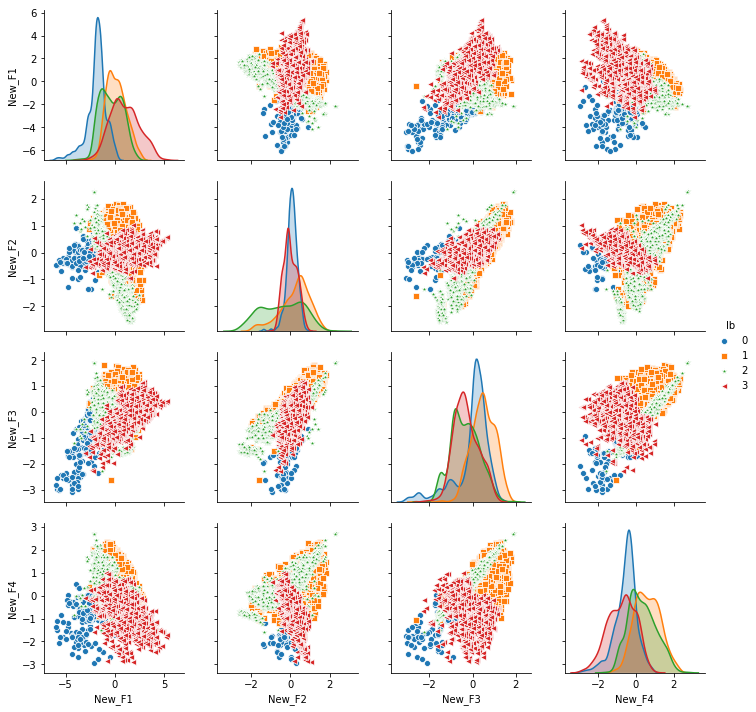

In [74]:
gmm = GaussianMixture(n_components=4, warm_start=True)
lb_rp = gmm.fit_predict(X_rp)

# pairplot
col_names = ['New_F1','New_F2','New_F3','New_F4']
X_df = pd.DataFrame(X_rp, columns=col_names)
X_c = X_df.copy()
X_c['lb'] = lb_rp
plt.figure()
ax = sns.pairplot(X_c, hue='lb', x_vars=col_names, y_vars=col_names, markers=['o', 's', '*', '<'])

## 3.4 IG

In [81]:
X_ig

array([[ 0.48997233, -0.45156979, -0.59874839],
       [-0.64132434,  0.1092551 , -0.91688883],
       [ 0.87067355, -0.45990456,  0.80670865],
       ...,
       [ 0.24690484, -0.79330141,  1.42332571],
       [-0.77897908, -0.38314646, -1.43252154],
       [-0.79467753, -0.64011223,  0.72034666]])

Text(0, 0.5, 'BSS / TSS')

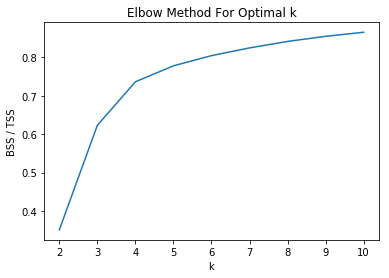

In [83]:
# Elbow Method
pes, wgs = elbow_method(X_ig, 2, 11)
plt.figure()
plt.plot(range(2, 11), pes)
plt.title('Elbow Method For Optimal k')
plt.xlabel('k')
plt.ylabel('BSS / TSS')
# k = 4

Optimal clusters:  4


Text(0.5, 1.0, 'Gap Values by Cluster Count')

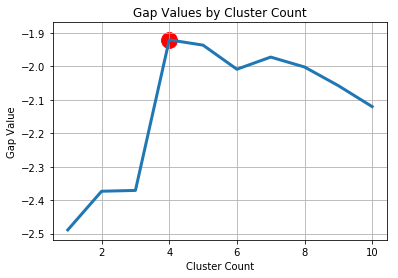

In [84]:
# Gap Statistic
optimalK = OptimalK(parallel_backend='joblib')
n_clusters = optimalK(X_ig, cluster_array=np.arange(1, 11))   # random actually
print('Optimal clusters: ', n_clusters)

plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3)
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
# consistent with elbow

/Users/Quintus/anaconda3/envs/cobra_py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

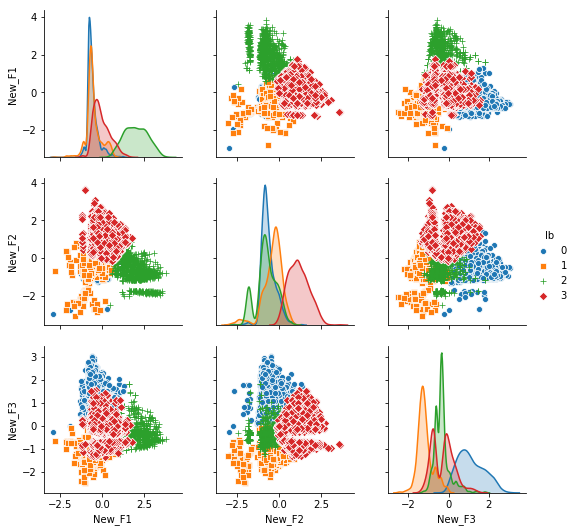

In [85]:
clstr = KMeans(n_clusters=4, random_state=0, verbose=0)
clstr.fit(X_ig)
lb_ig = clstr.labels_

# pairplot
col_names = ['New_F1','New_F2','New_F3']
X_df = pd.DataFrame(X_ig, columns=col_names)
X_c = X_df.copy()
X_c['lb'] = lb_ig
plt.figure()
ax = sns.pairplot(X_c, hue='lb', x_vars=col_names, y_vars=col_names, markers=['o', 's', '+', 'D'])


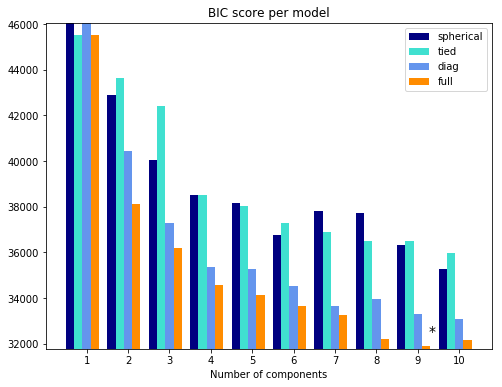

In [86]:
gauss_mix_model_selection(X_ig, k_ub=11, cv_types=['spherical', 'tied', 'diag', 'full'])

/Users/Quintus/anaconda3/envs/cobra_py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

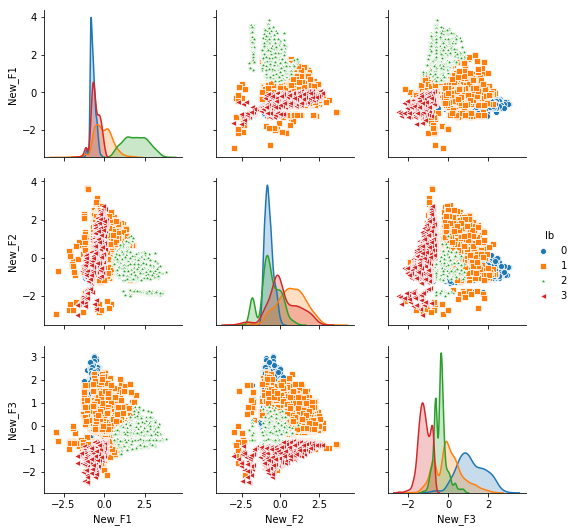

In [87]:
gmm = GaussianMixture(n_components=4, warm_start=True)
lb_ig = gmm.fit_predict(X_ig)

# pairplot
col_names = ['New_F1','New_F2','New_F3']
X_df = pd.DataFrame(X_ig, columns=col_names)
X_c = X_df.copy()
X_c['lb'] = lb_ig
plt.figure()
ax = sns.pairplot(X_c, hue='lb', x_vars=col_names, y_vars=col_names, markers=['o', 's', '*', '<'])

# 4. Dimensionality Reduction + NN Classification

In [206]:
X.head()

V1        V2        V3        V4        V5
0  0.489972 -0.451570 -1.048087 -0.598748 -0.020420
1 -0.641324  0.109255  0.292157 -0.916889  0.240245
2  0.870674 -0.459905  0.578212  0.806709  0.835325
3 -0.628497 -0.316313  1.934474 -1.427231 -0.136596
4 -0.596454  0.015939  2.043395 -1.688604 -0.948215

In [208]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: Class, dtype: int64

In [ ]:
# PCA, ICA, RP

In [231]:
def model_train_cv(X, y):
    K.clear_session()
    model = Sequential()
    model.add(Dense(20, activation='relu', name="hidden_1", input_dim=X.shape[1]))
    model.add(Dense(1, activation='sigmoid', name="op"))
    model.compile(optimizer=Adam(lr=1e-2), loss='binary_crossentropy', metrics=['accuracy'])
    
    rs = ShuffleSplit(n_splits=10, test_size=.2, random_state=0)
    score = []
    for train_idx, cv_idx in rs.split(X):
        if type(X) is pd.DataFrame:
            X_train, X_cv = X.iloc[train_idx], X.iloc[cv_idx]
            y_train, y_cv = y.iloc[train_idx], y.iloc[cv_idx]
        elif type(X) is np.ndarray:
            X_train, X_cv = X[train_idx, :], X[cv_idx, :]
            y_train, y_cv = y[train_idx], y[cv_idx]
        history = model.fit(X_train, y_train, validation_split=0, epochs=10, batch_size=256, verbose=0)
        auc = roc_auc_score(y_cv, model.predict_proba(X_cv))
        score.append(auc)
    return np.mean(score)

In [233]:
score_by_k = []
for k in range(1, X.shape[1]+1):
    pca = PCA(n_components=k)
    X_pca = pca.fit_transform(X)
    score_by_k.append(model_train_cv(X_pca, y))

In [234]:
score_by_k

[0.8006434032322549,
 0.8549729715317251,
 0.8712784469952828,
 0.8899008836209475,
 0.907435676690255]

# 5. Dimensionality Reduction + Clustering + NN Classification